In [1]:
import paddle
import numpy as np
from paddle.nn import Conv2D,MaxPool2D,Linear

In [2]:
import paddle.nn.functional as F

In [3]:
class LeNet(paddle.nn.Layer):
    def __init__(self, num_classes = 1):
        super(LeNet,self).__init__()
        self.conv1 = Conv2D(in_channels=1,out_channels=6, kernel_size=5)
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.max_pool2 = MaxPool2D(kernel_size=2,stride=2)
        self.conv3 = Conv2D(in_channels=16,out_channels=120,kernel_size=4)
        self.fc1 = Linear(in_features=120,out_features=64)
        self.fc2 = Linear(in_features=64,out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.max_pool1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = paddle.reshape(x, [x.shape[0],-1])
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [11]:
# 测试网络形状
x = np.random.randn(3,1,28,28)
x = x.astype('float32')

model = LeNet(num_classes=10)
print(model.sublayers)
x = paddle.to_tensor(x)
for item in model.sublayers():
    try:
        x = item(x)
    except:
        x = paddle.reshape(x,[x.shape[0],-1])
        x = item(x)
    if len(item.parameters())==2:
        print(item.full_name(),x.shape,item.parameters()[0].shape,item.parameters()[1].shape)
    else:
        print(item.full_name(),x.shape)

<bound method Layer.sublayers of LeNet(
  (conv1): Conv2D(1, 6, kernel_size=[5, 5], data_format=NCHW)
  (max_pool1): MaxPool2D(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2D(6, 16, kernel_size=[5, 5], data_format=NCHW)
  (max_pool2): MaxPool2D(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2D(16, 120, kernel_size=[4, 4], data_format=NCHW)
  (fc1): Linear(in_features=120, out_features=64, dtype=float32)
  (fc2): Linear(in_features=64, out_features=10, dtype=float32)
)>
conv2d_6 [3, 6, 24, 24] [6, 1, 5, 5] [6]
max_pool2d_4 [3, 6, 12, 12]
conv2d_7 [3, 16, 8, 8] [16, 6, 5, 5] [16]
max_pool2d_5 [3, 16, 4, 4]
conv2d_8 [3, 120, 1, 1] [120, 16, 4, 4] [120]
linear_4 [3, 64] [120, 64] [64]
linear_5 [3, 10] [64, 10] [10]


In [17]:
# LeNet 识别手写数字
import os
import random
import paddle
import numpy as np
import paddle
from paddle.vision.transforms import ToTensor
from paddle.vision.datasets import MNIST

def train(model, opt, train_loader, valid_loader, epoch_num):
    paddle.device.set_device('gpu:0')
    print('start training....')
    model.train()
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            img = data[0]
            label = data[1]
            logits = model(img)
            loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
            loss = loss_func(logits,label)
            avg_loss = paddle.mean(loss)
            if batch_id % 2000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {:.4f}".format(epoch, batch_id, float(avg_loss.numpy())))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            img = data[0]
            label = data[1]
            logits = model(img)
            pred = F.softmax(logits)
            loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
            loss = loss_func(pred,label)
            acc = paddle.metric.accuracy(pred,label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {:.4f}/{:.4f}".format(np.mean(accuracies), np.mean(losses)))
        model.train()
    paddle.save(model.state_dict(),'mnist.pdpaprams')

model = LeNet(num_classes=10)
EPOCH_NUM = 5
opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9,parameters=model.parameters())
train_loader = paddle.io.DataLoader(MNIST(mode='train',transform=ToTensor()),batch_size=10,shuffle=True)
valid_loader = paddle.io.DataLoader(MNIST(mode='test',transform=ToTensor()),batch_size=10)

train(model, opt, train_loader, valid_loader, EPOCH_NUM)

start training....
epoch: 0, batch_id: 0, loss is: 2.5341
epoch: 0, batch_id: 2000, loss is: 2.2283
epoch: 0, batch_id: 4000, loss is: 2.0075
[validation] accuracy/loss: 0.7969/1.8616
epoch: 1, batch_id: 0, loss is: 0.8377
epoch: 1, batch_id: 2000, loss is: 0.3994
epoch: 1, batch_id: 4000, loss is: 0.6343
[validation] accuracy/loss: 0.8987/1.6341
epoch: 2, batch_id: 0, loss is: 0.1906
epoch: 2, batch_id: 2000, loss is: 0.6013
epoch: 2, batch_id: 4000, loss is: 0.5055
[validation] accuracy/loss: 0.9258/1.5822
epoch: 3, batch_id: 0, loss is: 0.1709
epoch: 3, batch_id: 2000, loss is: 0.2365
epoch: 3, batch_id: 4000, loss is: 0.1201
[validation] accuracy/loss: 0.9431/1.5585
epoch: 4, batch_id: 0, loss is: 0.2274
epoch: 4, batch_id: 2000, loss is: 0.5119
epoch: 4, batch_id: 4000, loss is: 0.1216
[validation] accuracy/loss: 0.9516/1.5429


查看数据集图片
iChallenge-PM中既有病理性近视患者的眼底图片，也有非病理性近视患者的图片，命名规则如下：

病理性近视（PM）：文件名以P开头

非病理性近视（non-PM）：

高度近视（high myopia）：文件名以H开头

正常眼睛（normal）：文件名以N开头

我们将病理性患者的图片作为正样本，标签为1； 非病理性患者的图片作为负样本，标签为0。从数据集中选取两张图片，通过LeNet提取特征，构建分类器，对正负样本进行分类，并将图片显示出来。代码如下所示：

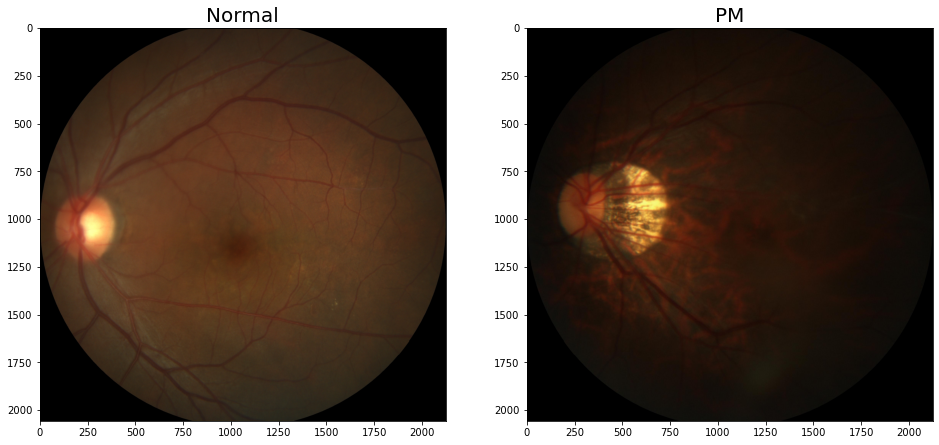

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

DATADIR = '../DATA/PALM-Training400/PALM-Training400/PALM-Training400'
file1 = 'N0012.jpg'
file2 = 'P0095.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

plt.figure(figsize=(16,8))
f = plt.subplot(121)
f.set_title('Normal',fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM',fontsize=20)
plt.imshow(img2)
plt.show()

In [31]:
img1.shape,img2.shape

((2056, 2124, 3), (2056, 2124, 3))

In [35]:
# 定义数据读取器
# 使用openCV读取器，将每张图片缩放到224*224并且将像素值调到【-1,1】
import cv2
import random
import numpy as np
import os

def transform_img(img):
    img = cv2.resize(img,(224,224))
    # 读入的图像的格式是【H,W,C】
    # 使用转置操作将其变成【C,H,W】
    img = np.transpose(img,(2,0,1))
    img = img.astype('float32')
    img = img/255
    img = img *2.0 - 1.0
    return img

def data_loader(datadir, batch_size=10, mode='train'):
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir,name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头高度近视， N开头视力正常
                # 高度近视和正常视力都不是病理性的，标签为0
                label = 0
            elif name[0]=='P':
                label = 1
            else:
                raise('not expect file name')
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1,1)
                yield imgs_array,labels_array
                batch_imgs = []
                batch_labels = []
        if len(batch_imgs)>0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1,1)
            yield imgs_array,labels_array
    return reader

#定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            filepath = os.path.join(datadir,name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头高度近视， N开头视力正常
                # 高度近视和正常视力都不是病理性的，标签为0
                label = 0
            elif name[0]=='P':
                label = 1
            else:
                raise('not expect file name')
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1,1)
                yield imgs_array,labels_array
                batch_imgs = []
                batch_labels = []
        if len(batch_imgs)>0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1,1)
            yield imgs_array,labels_array
    return reader            

In [38]:
# 查看数据集形状
train_loader = data_loader(DATADIR,batch_size=10,mode='train')
data_reader = train_loader()
data = next(data_reader)
print(data[0].shape,data[1].shape)

train_loader = data_loader(DATADIR,batch_size=10,mode='eval')
data_reader = train_loader()
data = next(data_reader)
print(data[0].shape,data[1].shape)

(10, 3, 224, 224) (10, 1)
(10, 3, 224, 224) (10, 1)
